## 기업 분석 리포트 에이전트
에이전트 Tool 구축하기

In [1]:
import pandas as pd
import yfinance as yf
from polygon import RESTClient
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
import os
from langchain_core.tools import tool
from pathlib import Path
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
os.getcwd()

'/Users/sguys99/Desktop/project/langchain-study/fc-agent/part4/ch4.StockAnalysisAgent'

### Polygon API

-  Polygon 홈페이지 !https://polygon.io/
-  Polygon 주가 정보 !https://polygon.io/dashboard

In [2]:
BASE_DIR = Path(os.getcwd())  # 현재 작업 디렉토리
DATA_DIR = BASE_DIR / "data"  # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / "charts"  # 차트 저장용 디렉토리

polygon_client = RESTClient(api_key=os.environ["POLYGON_API_KEY"])

### yfinance, Polygon API로 자사, 경쟁사 주식정보 가져오기

In [3]:
related_companies = polygon_client.get_related_companies("NVDA")
competitors = [i.ticker for i in related_companies]
competitors

['AMD',
 'META',
 'GOOGL',
 'GOOG',
 'TSLA',
 'MSFT',
 'AMZN',
 'AAPL',
 'INTC',
 'AVGO']

In [4]:
@tool
def fetch_stock_data(ticker: str, start_date: str, end_date: str):
    """Fetch stock data and compare with NASDAQ and competitors."""
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    nasdaq = yf.download("^IXIC", start=start_date, end=end_date, progress=False)

    df = pd.DataFrame(index=stock.index)
    df[f"{ticker}"] = stock["Close"]
    df["Nasdaq"] = nasdaq["Close"]

    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [i.ticker for i in related_companies]

    for comp in competitors:
        try:
            comp_ticker = comp.replace(".", "-") if "." in comp else comp
            comp_data = yf.download(
                comp_ticker, start=start_date, end=end_date, progress=False
            )
            if not comp_data.empty:
                df[comp] = comp_data["Close"]
        except Exception as e:
            continue

    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)
    return f"Stock file saved to {csv_path}"

In [5]:
fetch_stock_data.run(
    {"ticker": "NVDA", "start_date": "2023-01-01", "end_date": "2024-01-01"}
)

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/2597928491.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/2597928491.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download("^IXIC", start=start_date, end=end_date, progress=False)
/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/2597928491.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  comp_data = yf.download(
/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/2597928491.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  comp_data = yf.download(
/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/2597928491.py:17: FutureWarning: YF.download() has changed argument auto_adjust d

'Stock file saved to /Users/sguys99/Desktop/project/langchain-study/fc-agent/part4/ch4.StockAnalysisAgent/data/stock_data.csv'

### Polygon API로 재무 정보 가져오기

In [7]:
# import time

# client = polygon_client

# financials = []
# max_retries = 5
# sleep_sec = 2

# for attempt in range(max_retries):
#     try:
#         for f in client.vx.list_stock_financials("NVDA"):
#             if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - 3}-01-01":
#                 financials.append(f)
#             time.sleep(sleep_sec)  # 각 요청 사이에 대기
#         break  # 성공하면 루프 종료
#     except Exception as e:
#         if "429" in str(e):
#             print(f"429 Too Many Requests: {e}. Waiting before retrying...")
#             time.sleep(10)  # 429 발생 시 더 오래 대기
#         else:
#             raise
# else:
#     print("최대 재시도 횟수를 초과했습니다.")

KeyboardInterrupt: 

In [10]:
import time

@tool
def get_financial_data(ticker: str, num_years: int):
    """
    주어진 티커의 재무 데이터를 가져와 DataFrame으로 저장하고 파일 경로를 반환합니다.

    Parameters:
    ticker (str): 종목 코드
    num_years (int): 가져올 연도 수

    Returns:
    str: 저장된 파일 경로 메시지
    """
    client = polygon_client

    # 최근 n개년간 분기별 재무제표 데이터 수집
    financials = []
    max_retries = 5
    sleep_sec = 1
    for attempt in range(max_retries):
        try:
            for f in client.vx.list_stock_financials(ticker):
                if (
                    "Q" in f.fiscal_period
                    and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01"
                ):
                    financials.append(f)
                time.sleep(sleep_sec)  # 각 요청 사이에 대기
            break  # 성공하면 루프 종료
        except Exception as e:
            if "429" in str(e):
                print(f"429 Too Many Requests: {e}. Waiting before retrying...")
                time.sleep(2)  # 429 발생 시 더 오래 대기
            else:
                raise
    else:
        print("최대 재시도 횟수를 초과했습니다.")

    # DataFrame 생성할 데이터 목록 초기화
    data = {
        # 기본 정보
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        # 손익계산서 항목
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": [],
    }

    # 각 재무제표 항목에서 지표들을 추출하여 DataFrame 구성
    for i, f in enumerate(financials):
        # 기본 정보
        data["Fiscal Year"].append(f.fiscal_year)
        data["Fiscal Period"].append(f.fiscal_period)
        data["End Date"].append(f.end_date)

        # 재무제표 데이터 접근
        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income

        # 손익계산서 데이터 추출
        revenue = (
            getattr(is_.revenues, "value", None) if hasattr(is_, "revenues") else None
        )
        data["Revenues"].append(revenue)
        data["Cost of Revenue"].append(
            getattr(is_.cost_of_revenue, "value", None)
            if hasattr(is_, "cost_of_revenue")
            else None
        )
        data["Gross Profit"].append(
            getattr(is_.gross_profit, "value", None)
            if hasattr(is_, "gross_profit")
            else None
        )
        data["Operating Expenses"].append(
            getattr(is_.operating_expenses, "value", None)
            if hasattr(is_, "operating_expenses")
            else None
        )
        data["Operating Income"].append(
            getattr(is_.operating_expenses, "value", None)
            if hasattr(is_, "operating_expenses")
            else None
        )
        data["Basic EPS"].append(
            getattr(is_.basic_earnings_per_share, "value", None)
            if hasattr(is_, "basic_earnings_per_share")
            else None
        )

    # DataFrame 생성 및 정렬
    df = pd.DataFrame(data)
    df.sort_values(by="End Date", ascending=False, inplace=True)

    # 한글 컬럼명으로 변경
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익",
    }

    df.rename(columns=korean_columns, inplace=True)

    # CSV 파일로 저장
    csv_path = DATA_DIR / "finance_data.csv"
    df.to_csv(csv_path, encoding="utf-8-sig")  # utf-8-sig로 저장하여 한글 깨짐 방지
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

In [11]:
get_financial_data.run({"ticker": "NVDA", "num_years": 3})

'재무제표 데이터가 /Users/sguys99/Desktop/project/langchain-study/fc-agent/part4/ch4.StockAnalysisAgent/data/finance_data.csv에 저장되었습니다.'

### create_pandas_dataframe_agent로 데이터 분석 도구 만들기

In [12]:
@tool
def analyze_data(query: str):
    """저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다."""
    stock_csv_path = DATA_DIR / "stock_data.csv"
    finance_csv_path = DATA_DIR / "finance_data.csv"
    stock_df = pd.read_csv(stock_csv_path)
    finance_df = pd.read_csv(finance_csv_path)
    custom_prefix = f"""
    You are very smart analyst who can use stock_data and finance_data.
    Please analyze the data in various perspective to find valuable insight.
    You should always make the greatest output with accurate metrics and tables.
    stock_data path: {stock_csv_path}
    finance_data path: {finance_csv_path}
    """
    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        [stock_df, finance_df],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix=custom_prefix,
    )

    result = pandas_agent.run(query)
    return result

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_66924/1810733657.py:24: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = pandas_agent.run(query)




> Entering new AgentExecutor chain...


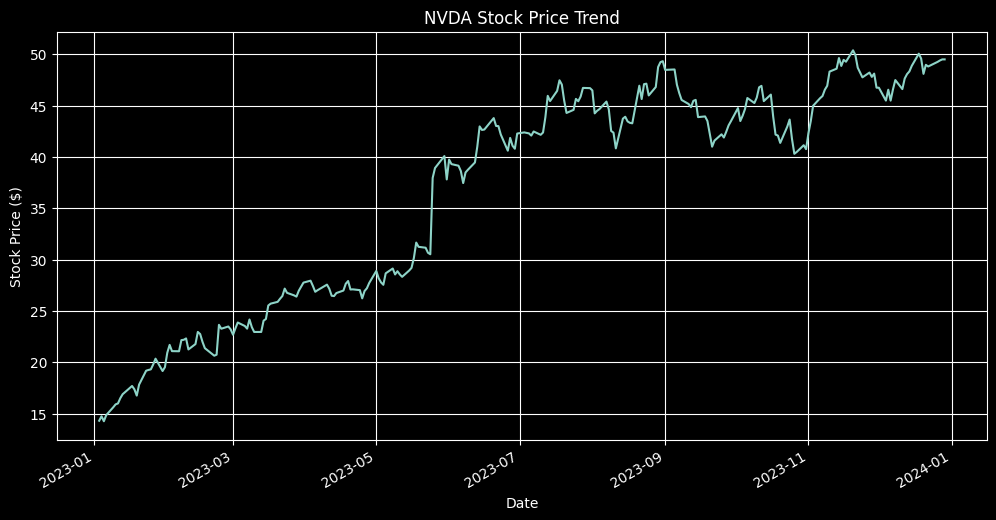


Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load stock data\ndf_stock = pd.read_csv('/Users/sguys99/Desktop/project/langchain-study/fc-agent/part4/ch4.StockAnalysisAgent/data/stock_data.csv')\n\n# Convert 'Date' column to datetime type\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Set 'Date' as the index\ndf_stock.set_index('Date', inplace=True)\n\n# Plot NVDA stock prices\ndf_stock['NVDA'].plot(figsize=(12, 6), title='NVDA Stock Price Trend', xlabel='Date', ylabel='Stock Price ($)', grid=True)\nplt.show()"}`


위 그래프는 2023년의 NVDA 주가 추이를 보여줍니다. 이 그래프에서 NVDA의 주가 변동을 시각적으로 확인할 수 있습니다. 주가는 시간에 따라 변동하며, 특정 시점에서 상승하거나 하락하는 경향을 보일 수 있습니다. 이러한 변동을 통해 투자자들은 매수 또는 매도 시점을 결정할 수 있습니다. 

추가적인 분석이 필요하다면 말씀해 주세요!

> Finished chain.


'위 그래프는 2023년의 NVDA 주가 추이를 보여줍니다. 이 그래프에서 NVDA의 주가 변동을 시각적으로 확인할 수 있습니다. 주가는 시간에 따라 변동하며, 특정 시점에서 상승하거나 하락하는 경향을 보일 수 있습니다. 이러한 변동을 통해 투자자들은 매수 또는 매도 시점을 결정할 수 있습니다. \n\n추가적인 분석이 필요하다면 말씀해 주세요!'

In [13]:
analyze_data.run({"query": "NVDA 가격 추이를 분석해줘"})

### 차트 생성 도구 만들기

In [14]:
@tool
def chart_generator(command: str):
    """이 도구는 create_pandas_dataframe_agent를 사용하여 차트를 생성하고 차트를 /charts 폴더에 저장합니다."""
    stock_data = pd.read_csv(DATA_DIR / "stock_data.csv")
    finance_data = pd.read_csv(DATA_DIR / "finance_data.csv")
    custom_prefix = """
    Please make the chart and save in './charts' folder.
    stock_data path is './data/stock_data.csv'.
    finance_data path is './data/finance_data.csv'
    """
    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model_name="gpt-4o"),
        [stock_data, finance_data],
        verbose=True,
        allow_dangerous_code=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        prefix=custom_prefix,
    )
    result = agent.invoke(command)
    return result



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock_data from CSV\nstock_data_path = './data/stock_data.csv'\ndf_stock = pd.read_csv(stock_data_path)\n\n# Convert 'Date' to datetime format\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Set 'Date' as the index\nnvda_data = df_stock.set_index('Date')['NVDA']\n\n# Plotting NVDA stock price\nplt.figure(figsize=(10, 5))\nnvda_data.plot(title='NVDA Stock Price', color='blue')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.grid(True)\nplt.tight_layout()\n\n# Save the plot\nplt.savefig('./charts/NVDA_stock_price.png')\nplt.show()"}`


FileNotFoundError: [Errno 2] No such file or directory: './charts/NVDA_stock_price.png'

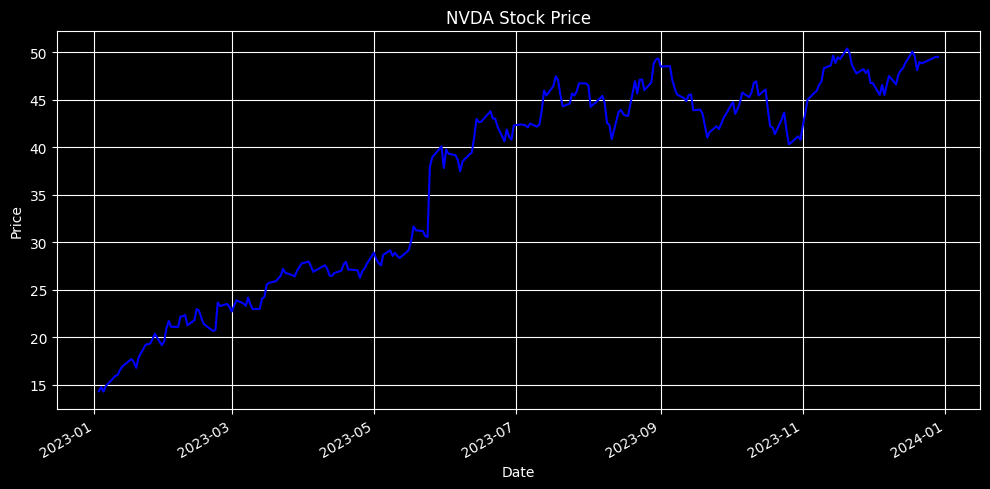

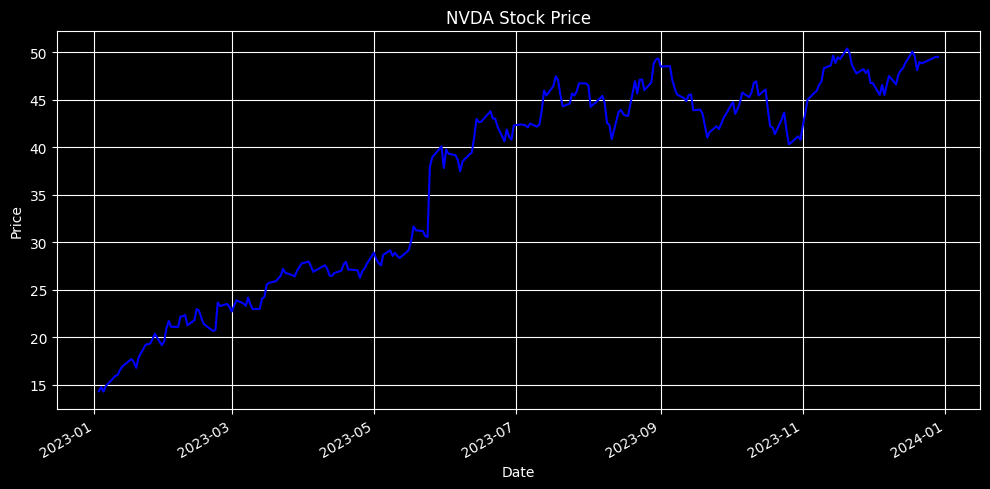


Invoking: `python_repl_ast` with `{'query': "import os\n\n# Create the charts directory if it doesn't exist\nos.makedirs('./charts', exist_ok=True)\n\n# Save the plot again\nplt.figure(figsize=(10, 5))\nnvda_data.plot(title='NVDA Stock Price', color='blue')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.grid(True)\nplt.tight_layout()\nplt.savefig('./charts/NVDA_stock_price.png')\nplt.show()"}`


The NVDA stock price chart has been successfully created and saved in the './charts' folder as 'NVDA_stock_price.png'.

> Finished chain.


{'input': 'NVDA stock price chart',
 'output': "The NVDA stock price chart has been successfully created and saved in the './charts' folder as 'NVDA_stock_price.png'."}

In [15]:
chart_generator.run({"command": "NVDA stock price chart"})